

# ♻️ AI Waste Segregation System 🗑️ - represented by Eco Thinkers
This project focuses on building a real-time AI-based waste classification system that can automatically identify different types of waste using a machine learning model. The main objective is to promote efficient waste segregation to support recycling and reduce environmental pollution.

We trained a Convolutional Neural Network (CNN) model using the TensorFlow/Keras framework to classify images into six waste categories: **battery**, **glass**,**metal**, **organic**, **paper**, and **plastic**. The dataset was sourced from a public repository on Kaggle.

## This notebook contains the full training pipeline, including:



*   Data loading and preprocessing
*   Data augmentation
*   CNN model design using MobileNetV2
*   Class imbalance handling
*   Model evaluation and metrics
*   Conversion to .tflite for real-time use


In [ ]:
# 📦 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# 📁 Dataset Setup
IMG_SIZE = 224
BATCH_SIZE = 32
data_dir = 'dataset'

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True
)

# ✅ Training Generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# ✅ Validation Generator
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 3098 images belonging to 6 classes.
Found 772 images belonging to 6 classes.


In [ ]:
print(train_gen.class_indices)


{'battery': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}


In [ ]:
# 📊 Class Weights
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weights_dict)

# 🧪 Custom Generator with Sample Weights
def weighted_generator(generator, class_weights_dict):
    while True:
        x_batch, y_batch = next(generator)
        sample_weights = np.array([class_weights_dict[int(label)] for label in y_batch])
        yield x_batch, y_batch, sample_weights

train_gen_with_weights = weighted_generator(train_gen, class_weights_dict)

Class Weights: {0: 1.0006459948320414, 1: 0.9872530274059911, 2: 1.0473292765382014, 3: 1.0164041994750657, 4: 1.0244708994708995, 5: 0.9320096269554753}


In [ ]:
# 🧠 Transfer Learning Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ❄️ Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# 🔓 Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ⚙️ Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 🛑 Callbacks
early = EarlyStopping(patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only=True)

# 🚀 Training
steps_per_epoch = len(train_gen)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 1,691,142 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
history = model.fit(
    train_gen_with_weights,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early, checkpoint]
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.3336 - loss: 1.6869 - val_accuracy: 0.4560 - val_loss: 1.4023
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7016 - loss: 0.9739 - val_accuracy: 0.5803 - val_loss: 1.1316
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8032 - loss: 0.6870 - val_accuracy: 0.5920 - val_loss: 1.0097
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8467 - loss: 0.5265 - val_accuracy: 0.6580 - val_loss: 0.8735
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8860 - loss: 0.4234 - val_accuracy: 0.6788 - val_loss: 0.7851
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8877 - loss: 0.3761 - val_accuracy: 0.7241 - val_loss: 0.7057
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9003 - loss: 0.3350 - val_accuracy: 0.7604 - val_loss: 0.6282
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9056 - loss: 0.2966 - val_accuracy: 0.7591 - v

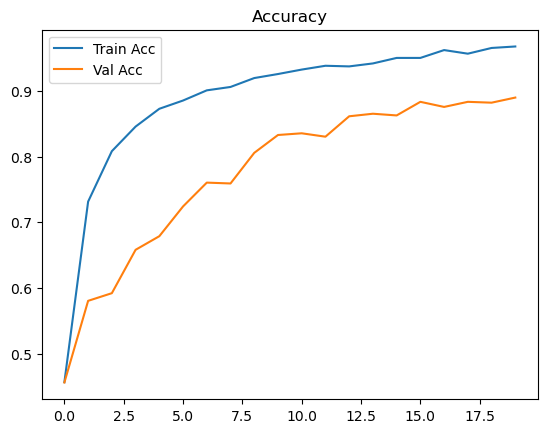

In [ ]:
# 📈 5. Performance Visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
# Save as .keras
model.save('models/waste_model.keras')

# Load from .keras
model = keras.models.load_model('models/waste_model.keras', compile=False)


In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save .tflite
with open("models/waste_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\vidhi\AppData\Local\Temp\tmp0psyghj2\assets


INFO:tensorflow:Assets written to: C:\Users\vidhi\AppData\Local\Temp\tmp0psyghj2\assets


Saved artifact at 'C:\Users\vidhi\AppData\Local\Temp\tmp0psyghj2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1736919893200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919894736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919895696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919897616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919894928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919902608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1735820213328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919893584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919894160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1736919898576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1735

25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Classification Report:

              precision    recall  f1-score   support

     battery       0.96      0.93      0.94       129
       glass       0.86      0.77      0.81       130
       metal       0.87      0.84      0.85       123
     organic       0.98      0.98      0.98       127
       paper       0.91      0.87      0.89       125
     plastic       0.73      0.87      0.79       138

    accuracy                           0.88       772
   macro avg       0.88      0.88      0.88       772
weighted avg       0.88      0.88      0.88       772



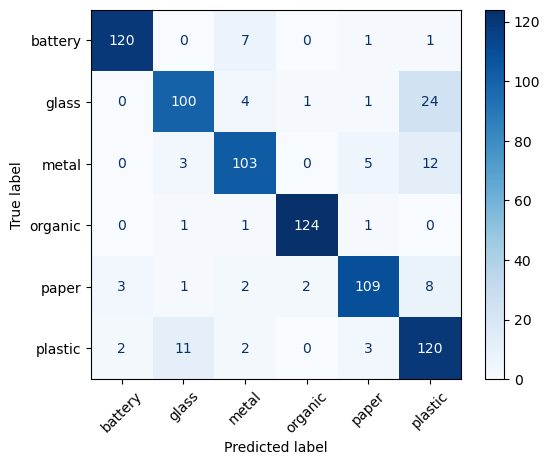

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# ✅ Load model (if not already loaded)
model = load_model('models/waste_model.keras')

# ✅ Predict on validation set
val_gen.reset()  # Ensures correct label order
Y_true = val_gen.classes
Y_pred = model.predict(val_gen, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# ✅ Class labels
class_labels = list(val_gen.class_indices.keys())

# 📋 Print classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# ✅ Optional: Show confusion matrix as well
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)




---
 # Thank You...



---


